# **Installing Required Libraries**

In [ ]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scikit-learn

# **QUESTION 1: Exploring Linear Discriminant Analysis (LDA) for One-vs-Rest Classification and k-NN Accuracy Comparison on MNIST**

## **Part 1: Apply LDA and Create One-vs-Rest Histograms**

In [ ]:
# Import necessary libraries
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Load MNIST data from openml
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data, mnist.target.astype(int)

In [ ]:
# Filter out digits 0 to 4 for a manageable subset
mask = y < 5
X, y = X[mask], y[mask]

In [ ]:
# Normalize the data by scaling pixel values to [0, 1]
X = X / 255.0

In [ ]:
# Dictionary to store LDA results for each digit (0-4)
lda_results = {}

# Perform LDA for each digit as "one-vs-rest"
for digit in range(5):
    # Create binary target where the current digit is positive (1) and others are negative (0)
    y_binary = (y == digit).astype(int)

    # Apply LDA and reduce to 1D for visualization
    lda = LDA(n_components=1)
    X_lda = lda.fit_transform(X, y_binary)

    # Store the 1D transformed data for plotting
    lda_results[digit] = X_lda


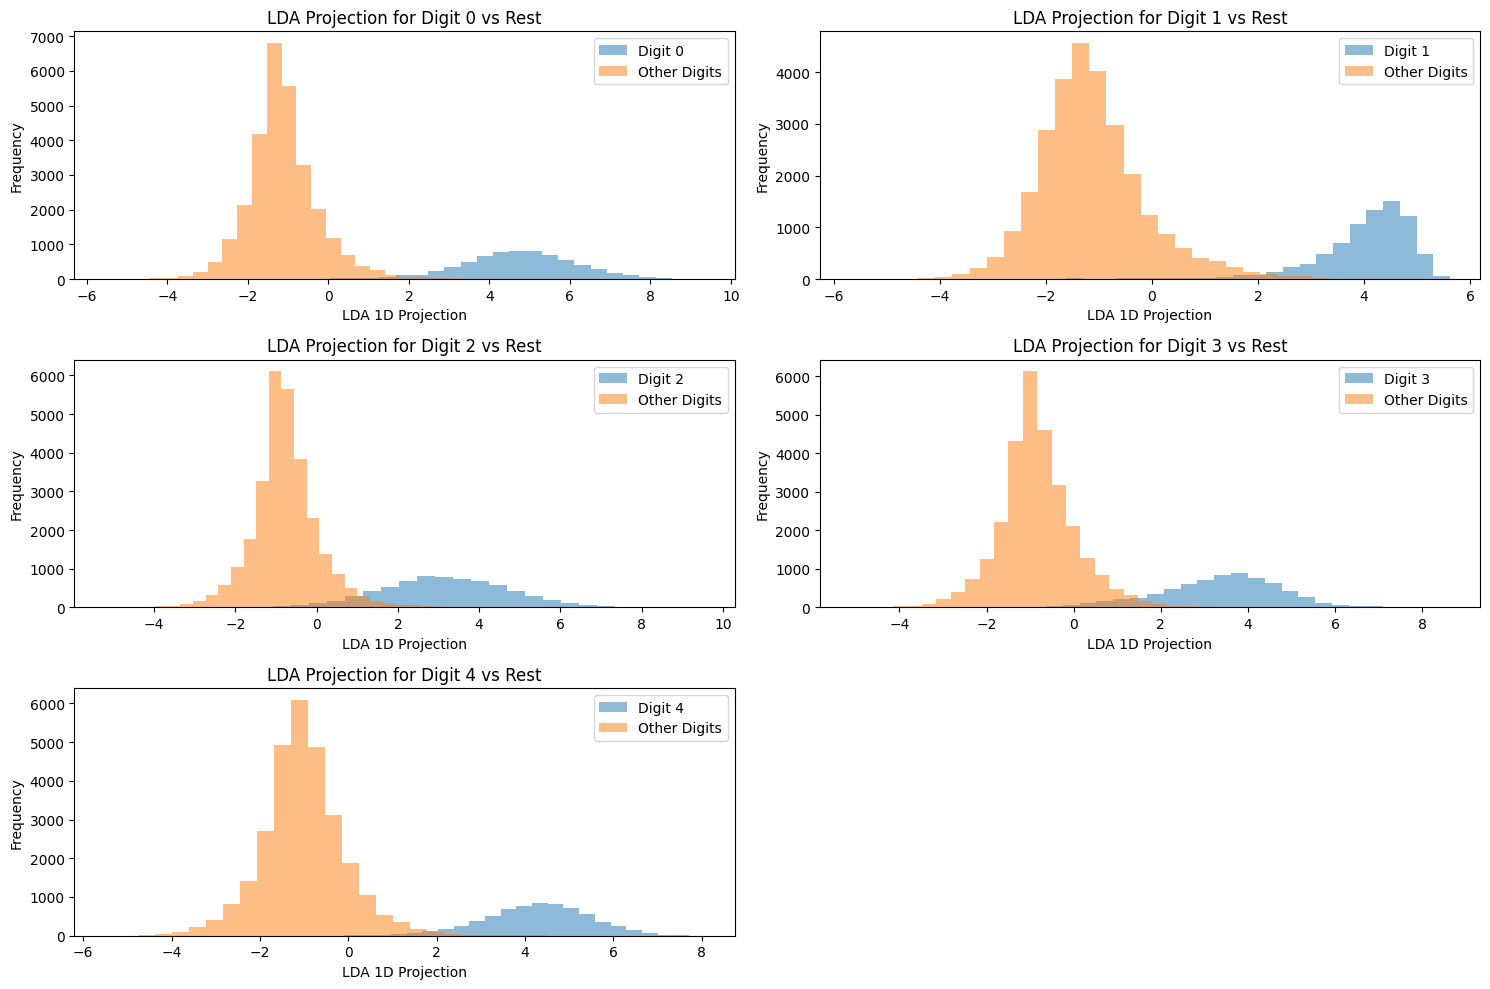

In [ ]:
# Plot histograms for each digit's one-vs-rest LDA result
plt.figure(figsize=(15, 10))

for digit, X_lda in lda_results.items():
    plt.subplot(3, 2, digit + 1)
    # Histogram for the current class (positive)
    plt.hist(X_lda[y == digit], bins=30, alpha=0.5, label=f'Digit {digit}')
    # Histogram for the rest (negative)
    plt.hist(X_lda[y != digit], bins=30, alpha=0.5, label='Other Digits')
    plt.title(f'LDA Projection for Digit {digit} vs Rest')
    plt.xlabel('LDA 1D Projection')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()


## **Part 2: k-NN Accuracy Comparison Before and After LDA**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [ ]:
# Split the dataset into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Instantiate k-NN with a default value of k (e.g., k=5)
knn = KNeighborsClassifier(n_neighbors=5)

# Train k-NN on the original high-dimensional dataset
knn.fit(X_train, y_train)

# Predict on the test set
y_pred = knn.predict(X_test)

# Calculate and print accuracy as the baseline
original_accuracy = accuracy_score(y_test, y_pred)
print(f"Baseline k-NN accuracy on the original dataset: {original_accuracy:.4f}")

Baseline k-NN accuracy on the original dataset: 0.9902


In [ ]:
# Apply LDA with the number of components set to 4 (one less than the number of classes)
lda = LDA(n_components=4)

# Fit LDA on the training data only
X_train_lda = lda.fit_transform(X_train, y_train)

# Transform both the training and test sets with the learned LDA transformation
X_test_lda = lda.transform(X_test)

In [ ]:
# Train k-NN on the LDA-transformed training data
knn_lda = KNeighborsClassifier(n_neighbors=5)
knn_lda.fit(X_train_lda, y_train)

# Predict on the LDA-transformed test set
y_pred_lda = knn_lda.predict(X_test_lda)

# Calculate and print accuracy on the LDA-transformed data
lda_accuracy = accuracy_score(y_test, y_pred_lda)
print(f"k-NN accuracy after LDA transformation: {lda_accuracy:.4f}")


k-NN accuracy after LDA transformation: 0.9611


In [ ]:
# Print comparison of accuracies before and after LDA
print(f"Baseline accuracy on original data: {original_accuracy:.4f}")
print(f"Accuracy after LDA transformation: {lda_accuracy:.4f}")

if lda_accuracy > original_accuracy:
    print("LDA transformation improved k-NN accuracy.")
else:
    print("LDA transformation did not improve k-NN accuracy.")


Baseline accuracy on original data: 0.9902
Accuracy after LDA transformation: 0.9611
LDA transformation did not improve k-NN accuracy.


# **Question 2: Use PCA (KL Transform) to obtain the reduced dimension representation of the face image**

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
import zipfile
import urllib.request

# Download the faces94.zip file
url = "http://cmp.felk.cvut.cz/~spacelib/faces/faces94.zip"
urllib.request.urlretrieve(url, "faces94.zip")

# Extract the faces94.zip file
with zipfile.ZipFile("faces94.zip", "r") as zip_ref:
    zip_ref.extractall("faces94")


In [ ]:
# Path to the dataset in Google Drive
drive_path = 'faces94/faces94'

# Define categories
categories = ['male', 'female', 'malestaff']

# Function to load all images from the given folder (male/female/malestaff)
def load_images_from_category(category):
    image_list = []
    category_path = os.path.join(drive_path, category)
    #print(f"Loading images from category: {category}")

    # Loop through subfolders inside each category
    for subfolder in os.listdir(category_path):
        subfolder_path = os.path.join(category_path, subfolder)
        if os.path.isdir(subfolder_path):  # Check if it's a subfolder
            for img_name in os.listdir(subfolder_path):
                img_path = os.path.join(subfolder_path, img_name)
                # Check if the file is an image (only JPG or PNG)
                if img_name.endswith('.jpg') or img_name.endswith('.png'):
                    #print(f"Loading image: {img_path}")
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    img_resized = cv2.resize(img, (100, 100))  # Resize to 100x100
                    image_list.append(img_resized)

    return image_list

In [ ]:
# Function to perform PCA and reconstruct image using given number of components
def reconstruct_image(pca, image_vector, n_components):
    # Subtract the mean from the image vector (center the image)
    centered_image = image_vector - pca.mean_

    # Project the centered image onto the selected principal components
    pcs_to_use = pca.components_[:n_components]  # Select components
    projected_image = np.dot(centered_image, pcs_to_use.T)  # Project onto the principal components

    # Reconstruct the image using the inverse transformation
    image_reconstructed = np.dot(projected_image, pcs_to_use) + pca.mean_

    # Reshape the reconstructed image to the original shape (100x100)
    return image_reconstructed.reshape(100, 100)

In [ ]:
# Function to perform PCA and reconstruct image for given category
def perform_pca_and_reconstruct(category, components=[5, 10, 25, 40, 50]):
    image_list = load_images_from_category(category)
    if len(image_list) == 0:
        print(f"No images found for category: {category}")
        return

    # Flatten the images and perform PCA
    image_matrix = np.array(image_list).reshape(len(image_list), -1)
    pca = PCA(n_components=min(components))
    pca.fit(image_matrix)

    # Reconstruct images using selected principal components
    fig, axes = plt.subplots(1, len(components), figsize=(15, 5))
    for i, n_components in enumerate(components):
        image_idx = 0  # We are reconstructing the first image for demonstration
        image_vector = image_matrix[image_idx]
        reconstructed_image = reconstruct_image(pca, image_vector, n_components)

        # Display reconstructed image
        axes[i].imshow(reconstructed_image, cmap='gray')
        axes[i].set_title(f"{n_components} components")
        axes[i].axis('off')

    plt.suptitle(f"Reconstructed images from {category} category")
    plt.show()

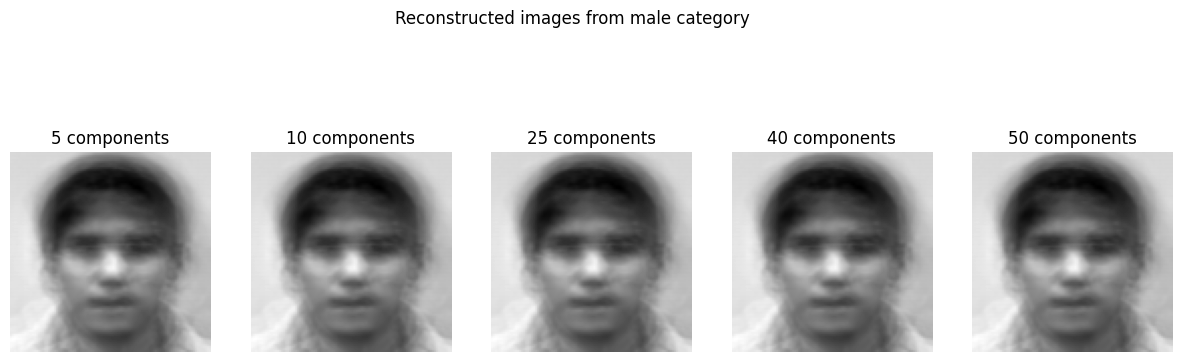

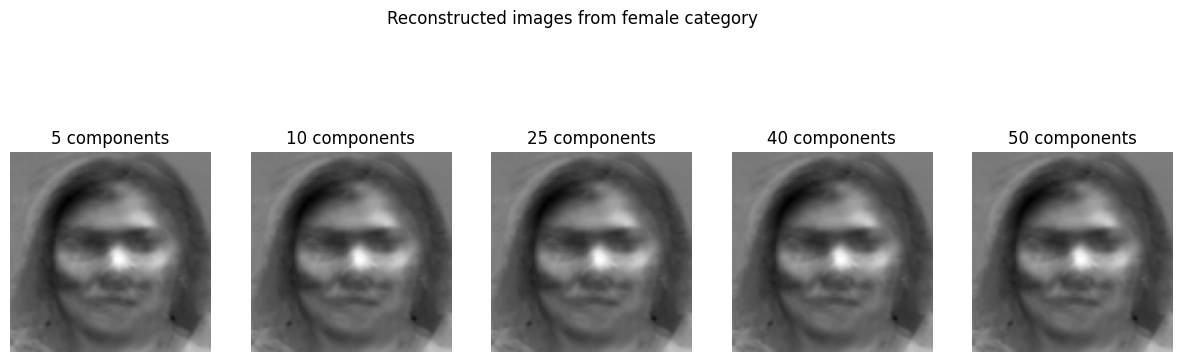

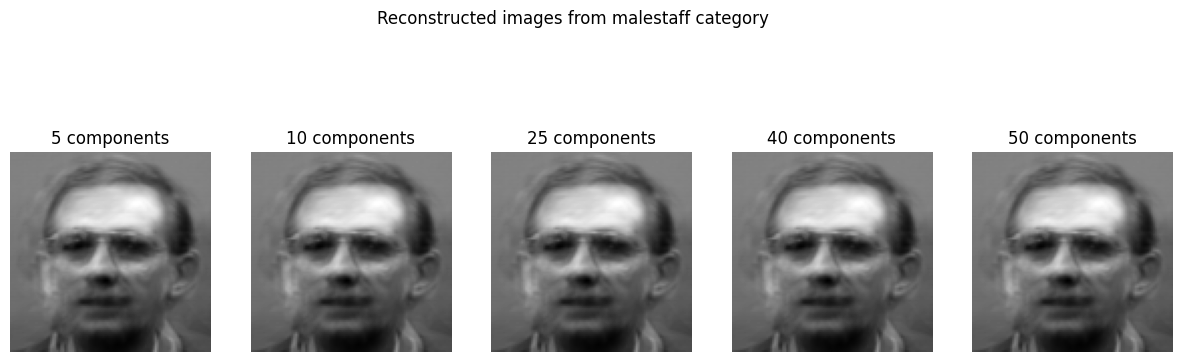

In [ ]:
# Perform PCA and reconstruct images for each category
for category in categories:
    perform_pca_and_reconstruct(category)